## MDN-v1.1 tensorflow with two independent MDN

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
import sklearn
import edward as ed
from sklearn.model_selection import train_test_split
%config InlineBackend.figure_format = 'retina'

def prepare_dataset(featurename='rss'):
    import scipy.io as sio
    data_1 = sio.loadmat('data_paper_WSNL/1000data.mat')
    data_2 = sio.loadmat('data_paper_WSNL/TXRXLoc2000.mat')
    local = data_2['RXm'][:1000,:2]
    rss = data_1['data_db_rss']
    aoa = data_1['data_db_aoa']
    toa = data_1['data_db_toa']
    data_4 = data_1['data'][:,18:24]
    data_5 = data_1['data'][:,24:]
    data_6 = data_1['data'][:,6:]
    data_whole = np.concatenate((rss,aoa,toa,data_4,data_5),axis =1)
    local_x = local[:,:1]
    local_y = local[:,1:]
    if featurename=='whole':
        return train_test_split(data_whole, local, random_state=42)
    elif featurename=='rss':
        return train_test_split(rss, local, random_state=42)
    elif featurename=='aoa':
        return train_test_split(aoa, local, random_state=42)
    elif featurename=='toa':
        return train_test_split(toa, local, random_state=42)
    elif featurename=='data_4':
        return train_test_split(data_4, local, random_state=42)
    elif featurename=='data_5':
        return train_test_split(data_5, local, random_state=42)
    elif featurename=='data_6':
        return train_test_split(data_6, local, random_state=42)
X_train, X_test, y_train, y_test = prepare_dataset(featurename='data_6')

print("Size of features in training data: {}".format(X_train.shape))
print("Size of output in training data: {}".format(y_train.shape))
print("Size of features in test data: {}".format(X_test.shape))
print("Size of output in test data: {}".format(y_test.shape))

fig,ax=plt.subplots(1,figsize=(6,6))
ax.scatter(y_train[:,0], y_train[:,1])
plt.show()

Size of features in training data: (750, 24)
Size of output in training data: (750, 2)
Size of features in test data: (250, 24)
Size of output in test data: (250, 2)


<Figure size 600x600 with 1 Axes>

In [31]:
tf.reset_default_graph()
input_data = tf.placeholder(shape=(None, 24), dtype=tf.float64, name='input_data')
target_data= tf.placeholder(shape=(None, 2), dtype=tf.float64, name='target_data')
hidden1 = tf.layers.dense(input_data, units=18, activation=tf.nn.relu, name='hidden1')
hidden2 = tf.layers.dense(hidden1, units=12, activation=tf.nn.relu, name='hidden2')
hidden3 = tf.layers.dense(hidden2, units=6, activation=tf.nn.relu, name='hidden3')
mixture_size = 3
out = tf.layers.dense(hidden3, units=6*mixture_size, activation=None, name='out')

p_x, p_y, mu_x, mu_y, sigma_x, sigma_y = tf.split(out, 6, 1)
p_x_out = tf.nn.softmax(p_x, name='prob_dist_x')
p_y_out = tf.nn.softmax(p_y, name='prob_dist_y')
sigma_x_out = tf.exp(sigma_x, name='sigma_x')
sigma_y_out = tf.exp(sigma_y, name='sigma_y')

factor = 1 / math.sqrt(2 * math.pi)
epsilon = 1e-5
target_x, target_y = tf.split(target_data, 2, 1)
tmp_x = - tf.square((target_x - mu_x)) / (2 * tf.square(tf.maximum(sigma_x_out, epsilon)))
x_normal = factor * tf.exp(tmp_x) / tf.maximum(sigma_x_out, epsilon)
tmp_y = - tf.square((target_y - mu_y)) / (2 * tf.square(tf.maximum(sigma_y_out, epsilon)))
y_normal = factor * tf.exp(tmp_y) / tf.maximum(sigma_y_out, epsilon)

loss_x = tf.reduce_sum(tf.multiply(x_normal, p_x_out), axis=1, keep_dims=True)
loss_x = -tf.log(tf.maximum(loss_x, epsilon))
loss_y = tf.reduce_sum(tf.multiply(y_normal, p_y_out), axis=1, keep_dims=True)
loss_y = -tf.log(tf.maximum(loss_y, epsilon))
loss = tf.sqrt(tf.square(tf.reduce_mean(loss_x))+tf.square(tf.reduce_mean(loss_y)))

train_step = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss_x)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

epochnum = 80000
loss_vals = np.zeros(epochnum)
for epoch in range(epochnum):
    _,loss_val = sess.run([train_step, loss], feed_dict={input_data: X_train , target_data: y_train})
    loss_vals[epoch] = loss_val
    if (epoch) % 100 == 0:
        print ('==>>> epoch: {}, train loss: {}'.format(epoch, loss_val))

==>>> epoch: 0, train loss: 16.281735335151488
==>>> epoch: 100, train loss: 16.281735335151488
==>>> epoch: 200, train loss: 16.281735335151488
==>>> epoch: 300, train loss: 16.281735335151488
==>>> epoch: 400, train loss: 16.281735335151488
==>>> epoch: 500, train loss: 16.281735335151488
==>>> epoch: 600, train loss: 16.281735335151488
==>>> epoch: 700, train loss: 16.281735335151488
==>>> epoch: 800, train loss: 16.281735335151488
==>>> epoch: 900, train loss: 16.281735335151488
==>>> epoch: 1000, train loss: 16.281735335151488
==>>> epoch: 1100, train loss: 16.281735335151488
==>>> epoch: 1200, train loss: 16.281735335151488
==>>> epoch: 1300, train loss: 16.281735335151488
==>>> epoch: 1400, train loss: 16.281735335151488
==>>> epoch: 1500, train loss: 16.281735335151488
==>>> epoch: 1600, train loss: 16.281735335151488
==>>> epoch: 1700, train loss: 16.281735335151488
==>>> epoch: 1800, train loss: 16.281735335151488
==>>> epoch: 1900, train loss: 16.281735335151488
==>>> epoch:

KeyboardInterrupt: 

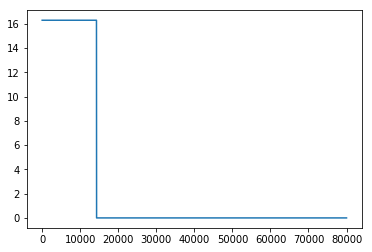

In [32]:
plt.plot(loss_vals)

<tf.Tensor 'split_2:0' shape=(?, 1) dtype=float64>

In [21]:
_,loss_val = sess.run([train_step, loss], feed_dict={input_data: X_train , target_data_x: y_train[:,0], target_data_y: y_train[:,1]})

ValueError: Cannot feed value of shape (750,) for Tensor 'target_data_x:0', which has shape '(?, 1)'